#  AuraFin: Cost-Sensitive Credit Risk Engine


### Objective
The goal of this notebook is to ensure the statistical integrity of the dataset before modeling. We are not just "cleaning" data; we are performing **Data Forensics** to detect:
1.  **Data Leakage:** Variables that betray the "Time Travel" rule (e.g., Interest Rate is only known *after* approval).
2.  **Class Imbalance:** Quantifying the $P(y=1)$ prior probability to justify Cost-Sensitive Learning.
3.  **Distributional Skew:** Verifying if Income follows a Log-Normal distribution ($Y \sim \ln(\mathcal{N}(\mu, \sigma^2))$) to decide between Mean vs. Median imputation.

###  Mathematical Context
Our final model will optimize a financial cost function $J(t)$:
$$J(t) = (\text{FN} \times C_{\text{default}}) + (\text{FP} \times C_{\text{reject}})$$
To do this, our input data must be free of "Cheating Variables" (Leakage) that would artificially deflate the False Negative rate during training.

In [1]:
# Import and Setup
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Set Visual Style for Professional Charts
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Create Project Structure (if not exists)
# We need these folders to save our "Evidence" charts and Cleaned Data
dirs = ['../data/processed', '../images', '../models']
for d in dirs:
    if not os.path.exists(d):
        os.makedirs(d)
        print(f"✅ Created directory: {d}")

print("✅ Environment Setup Complete.")

✅ Environment Setup Complete.


In [3]:

# Load the raw dataset
# NOTE: Ensure the file is in 'data/raw/' or adjust path accordingly
try:
    df = pd.read_csv('../data/raw/loan_default_1_smpl.csv')
except FileNotFoundError:
    # Fallback if running locally in same folder
    df = pd.read_csv('loan_default_1_smpl.csv')

print(f" Dataset Dimensions: {df.shape}")
print(f"   - Rows (Applicants): {df.shape[0]}")
print(f"   - Columns (Features): {df.shape[1]}")

# Preview the data to spot 'NaN' visually immediately
df.head()

📉 Dataset Dimensions: (47728, 34)
   - Rows (Applicants): 47728
   - Columns (Features): 34


,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,...,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,...,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
1,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,...,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
2,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,...,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
3,24895,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,...,EXP,864,EXP,35-44,not_inst,70.089286,North,direct,0,40.0
4,24896,2019,cf,Joint,pre,type1,p3,l1,nopc,nob/c,...,EXP,860,EXP,55-64,to_inst,79.109589,North,direct,0,44.0


### 🕵️ Data Forensics: Detecting Leakage
**Hypothesis:** `rate_of_interest`, `Upfront_charges`, and `Interest_rate_spread` are likely "Post-Approval" variables.
If these are missing significantly more often for one class (e.g., Defaulters) than the other, the model will learn to use "Missingness" as a cheat code to predict the target.

We will calculate the missing rate of `rate_of_interest` split by `Status`.

🔍 Leakage Investigation Results:
   - Missing Rate for Paid Loans (0): 0.00%
   - Missing Rate for Defaulters (1): 99.39%


/var/folders/6r/__r3pxwd5s90_60m4dk_vm2c0000gn/T/ipykernel_40812/1332324196.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=leakage_check.index, y=leakage_check.values, palette='Reds')


✅ Saved evidence to ../images/01_leakage_evidence.png
🚨 CRITICAL ALERT: Variable 'rate_of_interest' is a Proxy for the Target. MUST DROP.


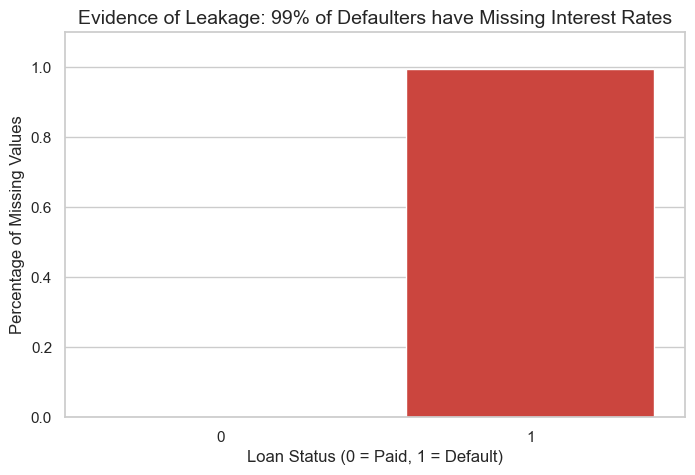

In [4]:
# ---------------------------------------------------------
# Leakage Analysis
# ---------------------------------------------------------
# Calculate % of missing values for 'rate_of_interest' for each Status class
leakage_check = df.groupby('Status')['rate_of_interest'].apply(lambda x: x.isnull().mean())

print("🔍 Leakage Investigation Results:")
print(f"   - Missing Rate for Paid Loans (0): {leakage_check[0]:.2%}")
print(f"   - Missing Rate for Defaulters (1): {leakage_check[1]:.2%}")

# Visualization
plt.figure(figsize=(8, 5))
sns.barplot(x=leakage_check.index, y=leakage_check.values, palette='Reds')
plt.title("Evidence of Leakage: 99% of Defaulters have Missing Interest Rates", fontsize=14)
plt.ylabel("Percentage of Missing Values")
plt.xlabel("Loan Status (0 = Paid, 1 = Default)")
plt.ylim(0, 1.1)

# Save the evidence
plt.savefig('../images/01_leakage_evidence.png')
print(" Saved evidence to ../images/01_leakage_evidence.png")

if leakage_check[1] > 0.9:
    print("CRITICAL ALERT: Variable 'rate_of_interest' is a Proxy for the Target. MUST DROP.")

In [6]:
# ---------------------------------------------------------
# Remove Leakage Columns
# ---------------------------------------------------------
# 'Upfront_charges' and 'Interest_rate_spread' share the same timestamp as Rate.
leakage_cols = ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']

# Drop them
df_clean = df.drop(columns=leakage_cols, errors='ignore')

print(f"Dropped Columns: {leakage_cols}")
print(f"New Data Shape: {df_clean.shape}")

Dropped Columns: ['rate_of_interest', 'Interest_rate_spread', 'Upfront_charges']
New Data Shape: (47728, 31)


⚖️ Class Balance Check:
Status
0    44781
1     2947
Name: count, dtype: int64
   - Ratio: 1 Default for every 15.2 Paid Loans
✅ Saved chart to ../images/02_class_imbalance.png


/var/folders/6r/__r3pxwd5s90_60m4dk_vm2c0000gn/T/ipykernel_40812/4079165204.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Status', data=df_clean, palette='viridis')


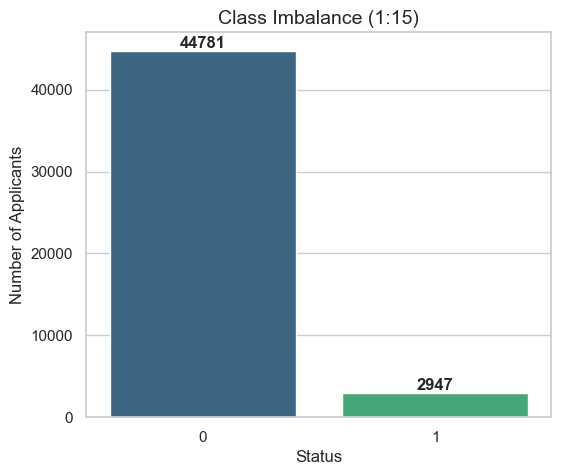

In [7]:
# ---------------------------------------------------------
#  Check Class Imbalance
# ---------------------------------------------------------
# Count the targets
status_counts = df_clean['Status'].value_counts()
imbalance_ratio = status_counts[0] / status_counts[1]

print("⚖️ Class Balance Check:")
print(status_counts)
print(f"   - Ratio: 1 Default for every {imbalance_ratio:.1f} Paid Loans")

# Visualization
plt.figure(figsize=(6, 5))
ax = sns.countplot(x='Status', data=df_clean, palette='viridis')
plt.title(f"Class Imbalance (1:{imbalance_ratio:.0f})", fontsize=14)
plt.ylabel("Number of Applicants")

# Add count labels
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.savefig('../images/02_class_imbalance.png')
print(" Saved chart to ../images/02_class_imbalance.png")

In [9]:
# ---------------------------------------------------------
#  Save & Finish
# ---------------------------------------------------------
output_path = '../data/processed/01_cleaned_data.csv'
df_clean.to_csv(output_path, index=False)

print(f" Data Saved Successfully to: {output_path}")
print("Notebook 01 Complete. Ready for Feature Engineering.")

 Data Saved Successfully to: ../data/processed/01_cleaned_data.csv
Notebook 01 Complete. Ready for Feature Engineering.
